# Instalação das Bibliotecas Necessárias

Este comando instala as principais bibliotecas usadas no notebook para machine learning e análise de dados:

- `scikit-learn`: para treinamento e avaliação de modelos.
- `lime`: para explicação local dos modelos.
- `matplotlib` e `pandas` e `numpy`: para visualização e manipulação de dados.

O parâmetro `--quiet` reduz a quantidade de mensagens exibidas durante a instalação, deixando a saída mais limpa.


In [2]:
!pip install scikit-learn lime matplotlib pandas numpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Importações das Bibliotecas Necessárias

Neste trecho do notebook, são importadas as principais bibliotecas usadas para manipulação de dados, modelagem, avaliação e explicação:

- `numpy` e `pandas`: para manipulação e análise de dados.
- `matplotlib.pyplot` e `seaborn`: para visualização gráfica.
- `sklearn.model_selection`, `ensemble`, `pipeline`, `preprocessing` e `metrics`: para preparar dados, treinar o modelo Random Forest, escalonar dados e avaliar a performance.
- `lime.lime_tabular`: para explicar localmente as previsões do modelo com LIME.
- `google.colab.files` e `io`: para fazer upload de arquivos CSV diretamente no ambiente Colab.

Essas importações configuram o ambiente para os próximos passos de treino e análise do modelo.


In [3]:
# ------------------ IMPORTAÇÕES ------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import lime
import lime.lime_tabular
from google.colab import files
import io

## 📄Este notebook realiza três etapas principais:

1. **UPLOAD DO CSV PARA TREINO**  
   - O usuário faz o upload de um arquivo CSV com dados históricos de clientes.  
   - O código lê o arquivo e armazena os dados em um DataFrame.

2. **PRÉ-PROCESSAMENTO**  
   - Cria a coluna `Valor_vs_Renda` caso não exista, calculando a razão entre `Valor_Solicitado` e `Renda_Mensal`.  
   - Cria a coluna `Aprovado` caso não exista, aplicando regras simples: aprova se o cliente tiver bom score de crédito (≥600), baixo endividamento (≤40%), tempo de emprego (≥6 meses) e sem histórico de inadimplência.  
   - Define as **features** (variáveis independentes) e o **target** (`Aprovado`).

3. **TREINO/TESTE DO MODELO + GRÁFICO**  
   - Divide os dados em treino (80%) e teste (20%).  
   - Cria um pipeline com `StandardScaler` (normalização) e `RandomForestClassifier` (modelo preditivo).  
   - Treina o modelo e calcula a **acurácia** das previsões.  
   - Exibe uma **matriz de confusão**, mostrando quantos clientes foram corretamente ou incorretamente classificados como “Aprovado” ou “Negado”.

📊 **Saídas importantes**:
- **Acurácia (%)** → mede a porcentagem de acertos do modelo.  
- **Matriz de Confusão** → visualiza o desempenho em cada classe (aprovado/negado).


📂 Faça upload do CSV de dados históricos para treinar o modelo:


Saving dados_credito_1000amostras_20atributos.csv to dados_credito_1000amostras_20atributos (1).csv
✅ Arquivo 'dados_credito_1000amostras_20atributos (1).csv' carregado!

📊 Acurácia do modelo: 100.00%


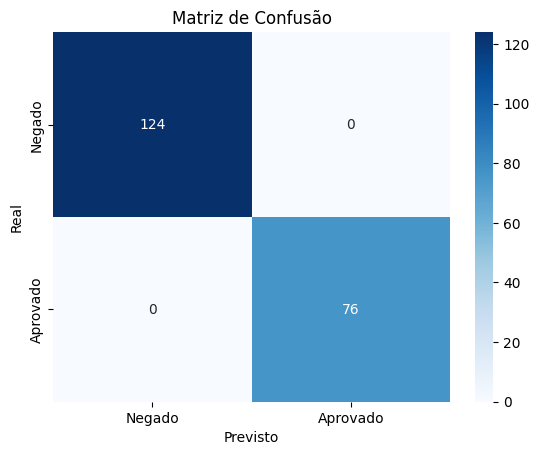

In [ ]:
# ------------------ ETAPA 1: UPLOAD DO CSV PARA TREINO ------------------
print("📂 Faça upload do CSV de dados históricos para treinar o modelo:")
uploaded = files.upload()

for nome_arquivo in uploaded.keys():
    df = pd.read_csv(io.BytesIO(uploaded[nome_arquivo]))
    print(f"✅ Arquivo '{nome_arquivo}' carregado!")
    break

# ------------------ PRÉ-PROCESSAMENTO ------------------
if "Valor_vs_Renda" not in df.columns:
    df["Valor_vs_Renda"] = (df["Valor_Solicitado"] / df["Renda_Mensal"]).round(2)

if "Aprovado" not in df.columns:
    df["Aprovado"] = np.where(
        (df["Score_Credito"] >= 600) &
        (df["Endividamento_%"] <= 40) &
        (df["Tempo_Emprego"] >= 6) &
        (df["Historico_Inadimplencia"] == 0),
        1, 0
    )

features = ["Renda_Mensal", "Score_Credito", "Endividamento_%",
            "Tempo_Emprego", "Historico_Inadimplencia", "Valor_vs_Renda"]
target = "Aprovado"

X = df[features]
y = df[target]

# ------------------ TREINO/TESTE DO MODELO + GRÁFICO ------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n📊 Acurácia do modelo: {acc*100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negado", "Aprovado"], yticklabels=["Negado", "Aprovado"])
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## 📄 Este trecho do notebook permite simular a análise de crédito de forma **manual** ou via **CSV com vários clientes**.

### **1. Escolha do Usuário**
- O programa pergunta se você deseja:
  1. Inserir dados de um único cliente manualmente.
  2. Enviar um CSV com dados de vários clientes.

### **2. Funções**
- `avaliar_cliente(...)` → aplica regras simples para aprovar ou negar crédito, exibindo dados do cliente.  
- `simular_parcelas(...)` → calcula o valor da parcela mensal considerando juros compostos.

### **3. Opção 1: Dados Manuais**
- Solicita informações financeiras do cliente (renda, score, parcelas, etc.).
- Calcula **endividamento** e **valor vs renda**.
- Usa o modelo treinado para prever aprovação.  
- Apresenta explicações com **LIME**.
- Simula diferentes prazos de financiamento (12, 24, 36, 48 meses), mostrando:
  - Valor da parcela
  - Percentual de endividamento
  - Probabilidade de aprovação
  - Explicação via LIME para cada cenário.

### **4. Opção 2: CSV de Clientes**
- Permite upload de um CSV com dados de vários clientes.
- Calcula métricas necessárias caso não estejam presentes.
- Mostra a **média das variáveis**.
- Usa **LIME** para explicar a previsão média.

📊 **Saídas importantes**:
- Aprovação ou reprovação de crédito (manual ou em lote).  
- Probabilidade de aprovação.  
- Explicações visuais via LIME para interpretação.



📌 Agora escolha como deseja simular:
1 - Inserir dados de um cliente manualmente
2 - Subir um CSV com vários clientes
Escolha (1 ou 2): 1

🧾 Insira os dados do cliente:
Renda Mensal (R$): 2000
Score de Crédito (0 a 1000): 620
Total de parcelas mensais (R$): 900
Tempo no emprego (meses): 12
Tem inadimplência? (Sim/Não): nao
Valor solicitado (R$): 20000

🔍 Resultado da Simulação:
❌ Crédito Não Aprovado.
Score: 620
Endividamento: 45.00%
Tempo no emprego: 12 meses
Nome limpo: Sim


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


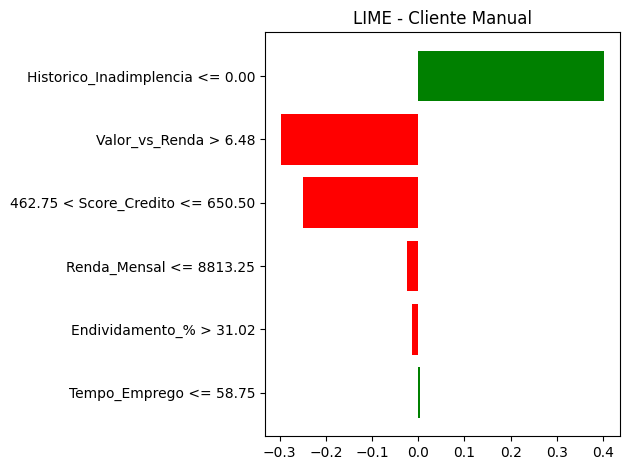

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



📊 Simulações de Parcelamento e Avaliação:

🔸 12x de R$ 1891.19 | Endividamento: 94.6% | Probabilidade de Aprovação: 49.00% → ❌ Negado


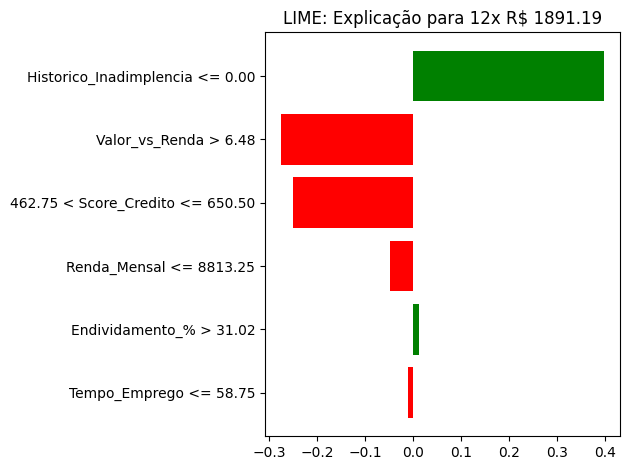


🔸 24x de R$ 1057.42 | Endividamento: 52.9% | Probabilidade de Aprovação: 49.00% → ❌ Negado


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


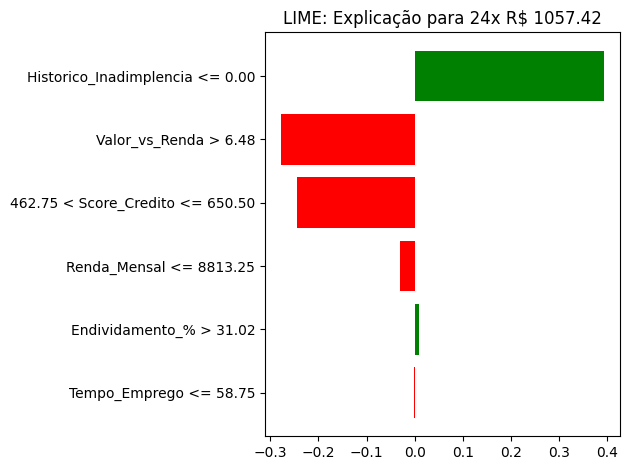

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔸 36x de R$ 784.66 | Endividamento: 39.2% | Probabilidade de Aprovação: 50.00% → ✅ Aprovado


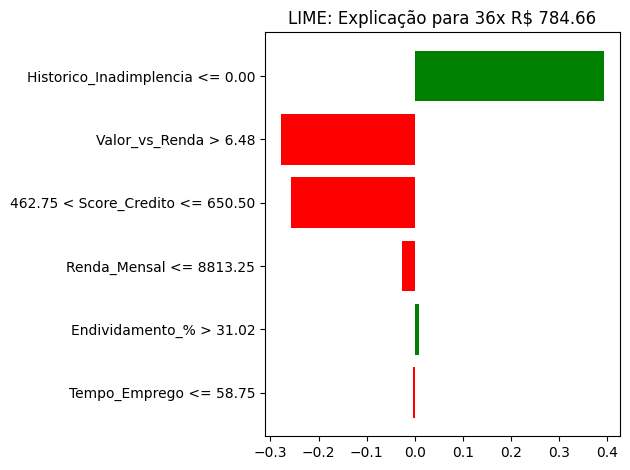

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



🔸 48x de R$ 652.04 | Endividamento: 32.6% | Probabilidade de Aprovação: 52.00% → ✅ Aprovado


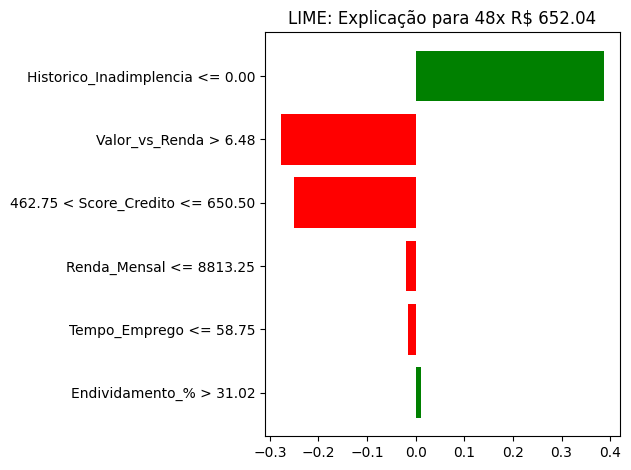

In [ ]:
# ------------------ ETAPA 2: ESCOLHA DO USUÁRIO ------------------
print("\n📌 Agora escolha como deseja simular:")
print("1 - Inserir dados de um cliente manualmente")
print("2 - Subir um CSV com vários clientes")
escolha = input("Escolha (1 ou 2): ").strip()

# ------------------ FUNÇÃO DE AVALIAÇÃO ------------------
def avaliar_cliente(renda, score, endividamento, tempo_emprego, nome_limpo):
    print("\n🔍 Resultado da Simulação:")
    if score >= 600 and endividamento <= 40 and tempo_emprego >= 6 and nome_limpo:
        print("✅ Crédito Aprovado!")
    else:
        print("❌ Crédito Não Aprovado.")
    print(f"Score: {score}")
    print(f"Endividamento: {endividamento:.2f}%")
    print(f"Tempo no emprego: {tempo_emprego} meses")
    print(f"Nome limpo: {'Sim' if nome_limpo else 'Não'}")

# ------------------ FUNÇÃO DE SIMULAÇÃO DE PARCELAS ------------------
def simular_parcelas(valor, meses, juros_mensal=0.02):
    """Calcula o valor da parcela mensal com juros compostos."""
    if juros_mensal == 0:
        return valor / meses
    parcela = valor * (juros_mensal * (1 + juros_mensal)**meses) / ((1 + juros_mensal)**meses - 1)
    return parcela

# ------------------ OPÇÃO 1: DADOS MANUAIS ------------------
if escolha == "1":
    print("\n🧾 Insira os dados do cliente:")
    renda = float(input("Renda Mensal (R$): "))
    score = int(input("Score de Crédito (0 a 1000): "))
    parcelas = float(input("Total de parcelas mensais (R$): "))
    tempo_emprego = int(input("Tempo no emprego (meses): "))
    inadimplente = input("Tem inadimplência? (Sim/Não): ").strip().lower()
    valor_solicitado = float(input("Valor solicitado (R$): "))

    endividamento = (parcelas / renda) * 100
    nome_limpo = (inadimplente != 'sim')
    valor_vs_renda = valor_solicitado / renda

    entrada = np.array([[renda, score, endividamento, tempo_emprego, 0 if nome_limpo else 1, valor_vs_renda]])

    # Previsão e explicação
    pred = pipeline.predict(entrada)
    avaliar_cliente(renda, score, endividamento, tempo_emprego, nome_limpo)

    exp = explainer.explain_instance(entrada[0], pipeline.predict_proba)
    exp.as_pyplot_figure()
    plt.title("LIME - Cliente Manual")
    plt.tight_layout()
    plt.show()

    # ----------- SIMULAÇÕES COM PRAZOS DIFERENTES ------------
    print("\n📊 Simulações de Parcelamento e Avaliação:")
    for prazo in [12, 24, 36, 48]:
        parcela_mensal = simular_parcelas(valor_solicitado, prazo)
        endividamento_sim = (parcela_mensal / renda) * 100
        valor_vs_renda_sim = valor_solicitado / renda
        entrada_sim = np.array([[renda, score, endividamento_sim, tempo_emprego, 0 if nome_limpo else 1, valor_vs_renda_sim]])
        prob_sim = pipeline.predict_proba(entrada_sim)[0][1]
        status = "✅ Aprovado" if prob_sim >= 0.5 else "❌ Negado"

        print(f"\n🔸 {prazo}x de R$ {parcela_mensal:.2f} | Endividamento: {endividamento_sim:.1f}% | Probabilidade de Aprovação: {prob_sim:.2%} → {status}")

        exp_sim = explainer.explain_instance(entrada_sim[0], pipeline.predict_proba, num_features=6)
        fig = exp_sim.as_pyplot_figure()
        plt.title(f"LIME: Explicação para {prazo}x R$ {parcela_mensal:.2f}")
        plt.tight_layout()
        plt.show()

# ------------------ OPÇÃO 2: CSV DE CLIENTES ------------------
elif escolha == "2":
    print("📂 Faça upload do CSV com os dados dos clientes:")
    uploaded2 = files.upload()

    for nome_arquivo in uploaded2.keys():
        novos = pd.read_csv(io.BytesIO(uploaded2[nome_arquivo]))
        break

    if "Valor_vs_Renda" not in novos.columns:
        novos["Valor_vs_Renda"] = (novos["Valor_Solicitado"] / novos["Renda_Mensal"]).round(2)

    if "Endividamento_%" not in novos.columns and "Parcelas" in novos.columns:
        novos["Endividamento_%"] = (novos["Parcelas"] / novos["Renda_Mensal"]) * 100

    media = novos[features].mean().values.reshape(1, -1)
    print("\n📊 Média dos dados dos clientes do CSV:")
    display(novos[features].mean())

    exp = explainer.explain_instance(media[0], pipeline.predict_proba)
    exp.as_pyplot_figure()
    plt.title("LIME - Média dos Clientes do CSV")
    plt.tight_layout()
    plt.show()

else:
    print("❌ Opção inválida. Execute novamente.")

## 📊 Análise Visual e Exploratória com o Cliente Manual

Neste bloco, os dados do cliente manual são adicionados ao dataframe original para análise conjunta.

### Principais visualizações:
- **Dispersão Score x Endividamento**: mostra a distribuição dos clientes aprovados e negados, destacando o cliente manual em azul.
- **Boxplots por aprovação**: compara Score, Renda, Endividamento e Tempo de emprego entre clientes aprovados e negados, destacando o valor do cliente manual.
- **Análise exploratória geral**: histogramas e contagem para as variáveis principais do dataset, com linhas indicando os valores do cliente manual.

Esses gráficos ajudam a entender onde o cliente manual se posiciona em relação ao histórico geral, facilitando interpretações visuais sobre o perfil e a aprovação.

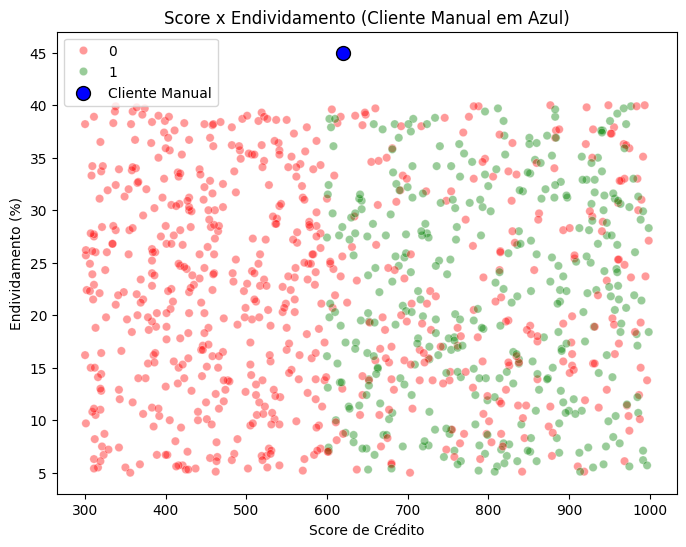

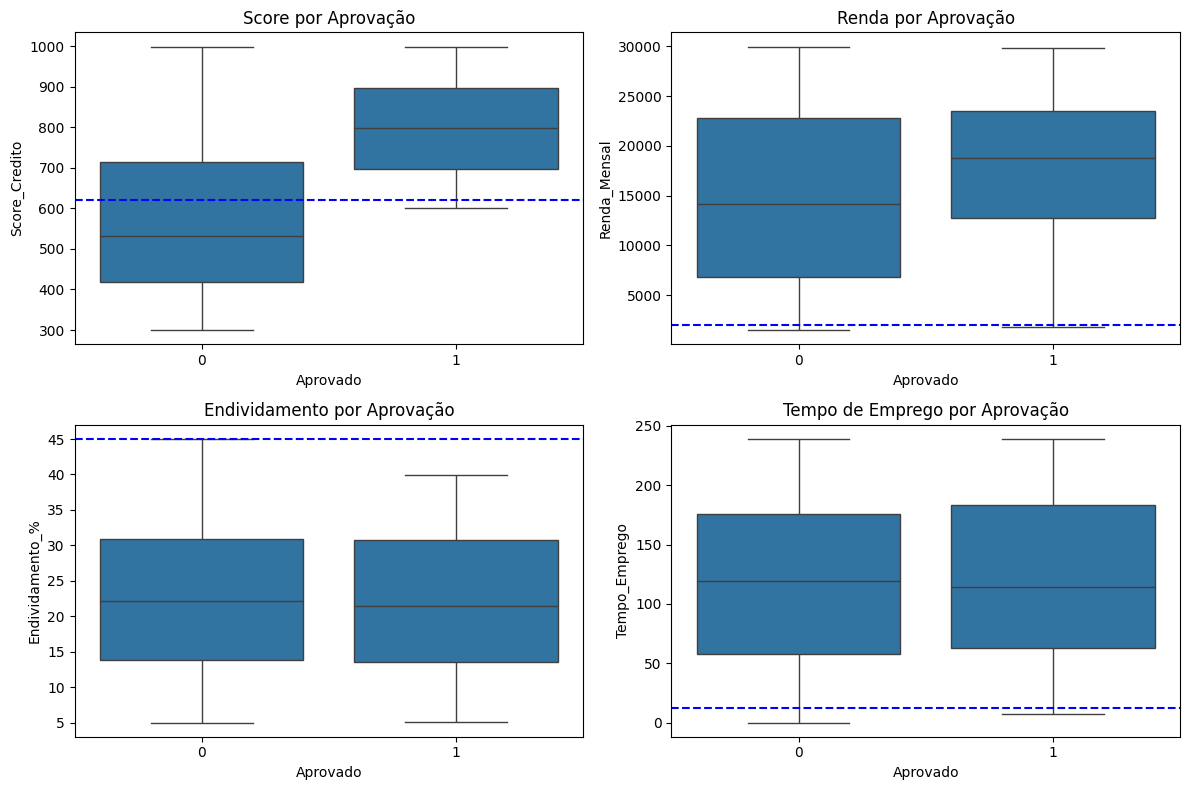

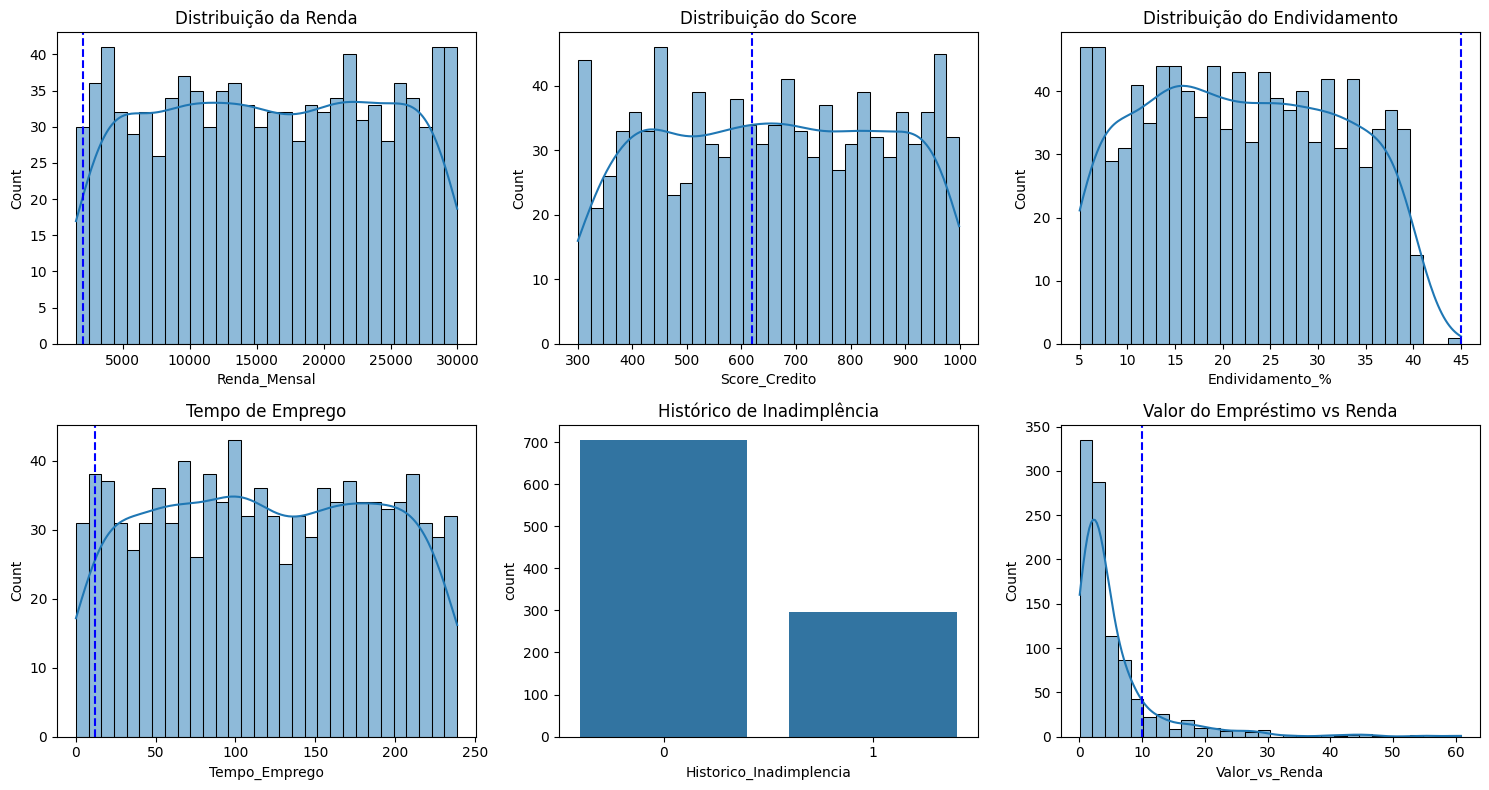

In [ ]:
    # ------------------ CLIENTE NO DATAFRAME ------------------
    cliente_manual = pd.DataFrame([{
        "Renda_Mensal": renda,
        "Score_Credito": score,
        "Endividamento_%": endividamento,
        "Tempo_Emprego": tempo_emprego,
        "Historico_Inadimplencia": 0 if nome_limpo else 1,
        "Valor_vs_Renda": valor_vs_renda,
        "Aprovado": pred[0]
    }])
    df = pd.concat([df, cliente_manual], ignore_index=True)

    # ------------------ ANÁLISE VISUAL COM O CLIENTE ------------------

    # -------- DISPERSÃO SCORE x ENDIVIDAMENTO --------
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df[:-1], x="Score_Credito", y="Endividamento_%", hue="Aprovado", palette=["red", "green"], alpha=0.4)
    plt.scatter(score, endividamento, color="blue", s=100, label="Cliente Manual", edgecolor="black")
    plt.title("Score x Endividamento (Cliente Manual em Azul)")
    plt.xlabel("Score de Crédito")
    plt.ylabel("Endividamento (%)")
    plt.legend()
    plt.show()

    # -------- BOXPLOTS POR APROVAÇÃO --------
    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    sns.boxplot(x="Aprovado", y="Score_Credito", data=df)
    plt.axhline(score, color='blue', linestyle='--', label="Cliente")
    plt.title("Score por Aprovação")

    plt.subplot(2,2,2)
    sns.boxplot(x="Aprovado", y="Renda_Mensal", data=df)
    plt.axhline(renda, color='blue', linestyle='--')
    plt.title("Renda por Aprovação")

    plt.subplot(2,2,3)
    sns.boxplot(x="Aprovado", y="Endividamento_%", data=df)
    plt.axhline(endividamento, color='blue', linestyle='--')
    plt.title("Endividamento por Aprovação")

    plt.subplot(2,2,4)
    sns.boxplot(x="Aprovado", y="Tempo_Emprego", data=df)
    plt.axhline(tempo_emprego, color='blue', linestyle='--')
    plt.title("Tempo de Emprego por Aprovação")

    plt.tight_layout()
    plt.show()

    # -------- ANÁLISE EXPLORATÓRIA GERAL --------
    fig, axs = plt.subplots(2,3, figsize=(15,8))

    sns.histplot(df["Renda_Mensal"], bins=30, ax=axs[0,0], kde=True)
    axs[0,0].axvline(renda, color='blue', linestyle='--')
    axs[0,0].set_title("Distribuição da Renda")

    sns.histplot(df["Score_Credito"], bins=30, ax=axs[0,1], kde=True)
    axs[0,1].axvline(score, color='blue', linestyle='--')
    axs[0,1].set_title("Distribuição do Score")

    sns.histplot(df["Endividamento_%"], bins=30, ax=axs[0,2], kde=True)
    axs[0,2].axvline(endividamento, color='blue', linestyle='--')
    axs[0,2].set_title("Distribuição do Endividamento")

    sns.histplot(df["Tempo_Emprego"], bins=30, ax=axs[1,0], kde=True)
    axs[1,0].axvline(tempo_emprego, color='blue', linestyle='--')
    axs[1,0].set_title("Tempo de Emprego")

    sns.countplot(x="Historico_Inadimplencia", data=df, ax=axs[1,1])
    axs[1,1].set_title("Histórico de Inadimplência")

    sns.histplot(df["Valor_vs_Renda"], bins=30, ax=axs[1,2], kde=True)
    axs[1,2].axvline(valor_vs_renda, color='blue', linestyle='--')
    axs[1,2].set_title("Valor do Empréstimo vs Renda")

    plt.tight_layout()
    plt.show()

## 📈 Importância das Features no Modelo

Este trecho extrai a importância de cada variável no modelo Random Forest treinado e exibe um gráfico de barras.

- Mostra quais características (features) têm maior impacto na decisão do modelo.
- Ajuda a identificar quais variáveis são mais relevantes para a previsão de aprovação de crédito.
- O gráfico facilita a interpretação visual da contribuição de cada feature para o modelo.


/tmp/ipython-input-4202638066.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias, y=features, palette="viridis")


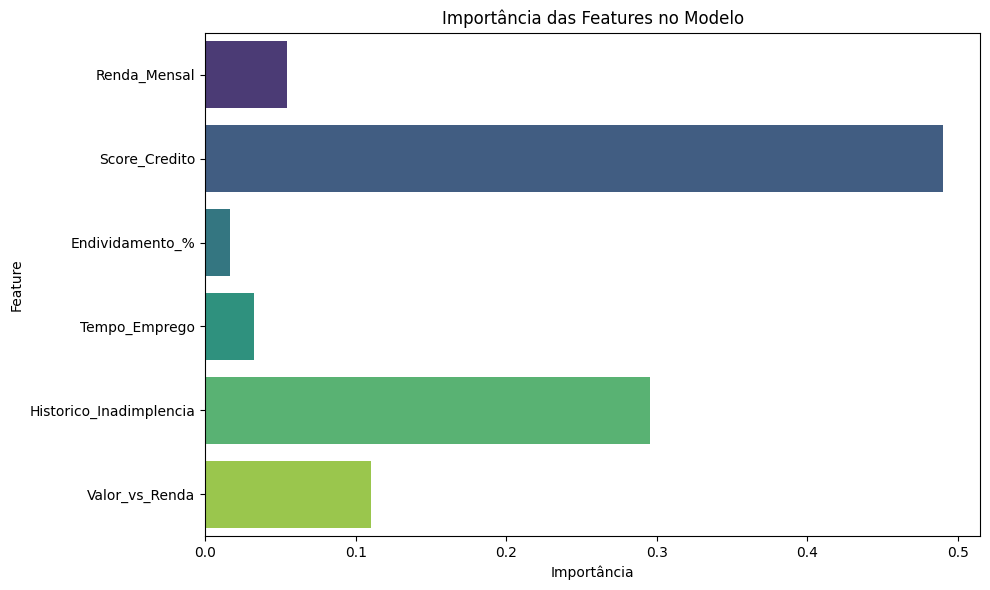

In [ ]:
importancias = pipeline.named_steps['randomforestclassifier'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importancias, y=features, palette="viridis")
plt.title("Importância das Features no Modelo")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 📊 Distribuição das Probabilidades de Aprovação

Este código calcula as probabilidades previstas de aprovação para todos os clientes no conjunto de dados e plota sua distribuição.

- O histograma mostra como as probabilidades se distribuem entre os clientes.
- A linha vermelha tracejada indica o limiar de decisão de 50% para classificar um cliente como aprovado ou negado.
- Essa visualização ajuda a entender o quão confiantes as previsões do modelo estão em relação aos casos.


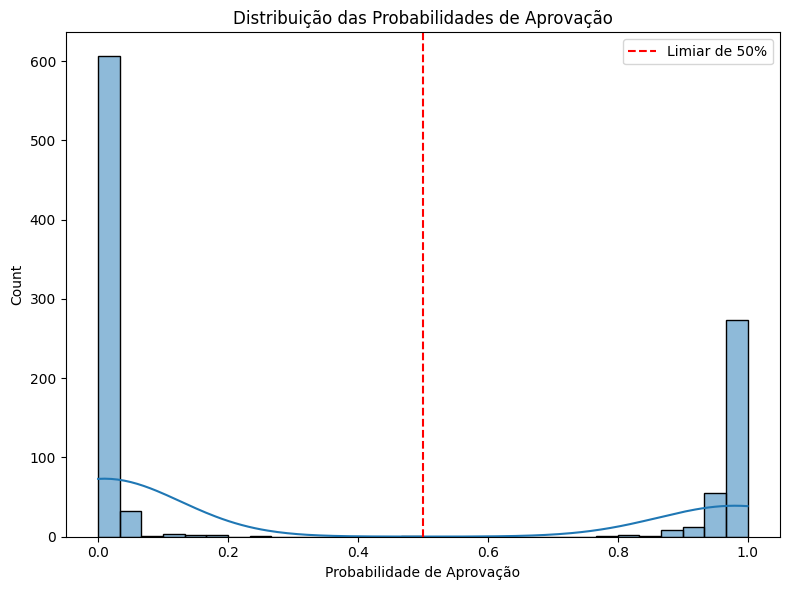

In [ ]:
probs = pipeline.predict_proba(df[features])[:,1]
plt.figure(figsize=(8,6))
sns.histplot(probs, bins=30, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Limiar de 50%')
plt.title("Distribuição das Probabilidades de Aprovação")
plt.xlabel("Probabilidade de Aprovação")
plt.legend()
plt.tight_layout()
plt.show()


## 🔗 Mapa de Correlação entre Variáveis

Este gráfico exibe a correlação entre as variáveis do conjunto de dados utilizadas no modelo, incluindo o alvo "Aprovado".

- Os valores variam de -1 a 1, indicando a força e direção da relação entre as variáveis.
- Cores quentes (vermelho) indicam correlação positiva forte, cores frias (azul) indicam correlação negativa.
- Essa análise ajuda a identificar quais variáveis estão mais relacionadas ao resultado da aprovação de crédito.


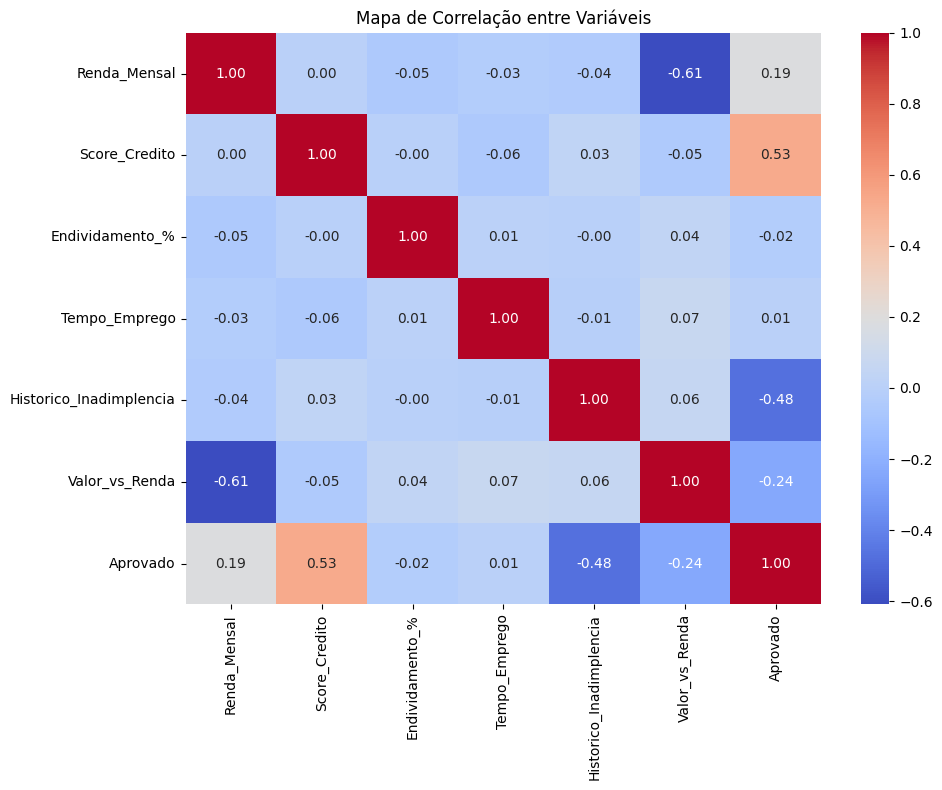

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[features + ["Aprovado"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação entre Variáveis")
plt.tight_layout()
plt.show()


## 🔄 Relação entre Features por Aprovação

Este gráfico utiliza o `pairplot` para mostrar as relações entre as variáveis do dataset, destacando a aprovação do crédito (`Aprovado`).  
Cada ponto representa um cliente, colorido em vermelho para não aprovados e verde para aprovados.  
O gráfico ajuda a visualizar padrões e diferenças entre as classes, facilitando a análise exploratória dos dados.


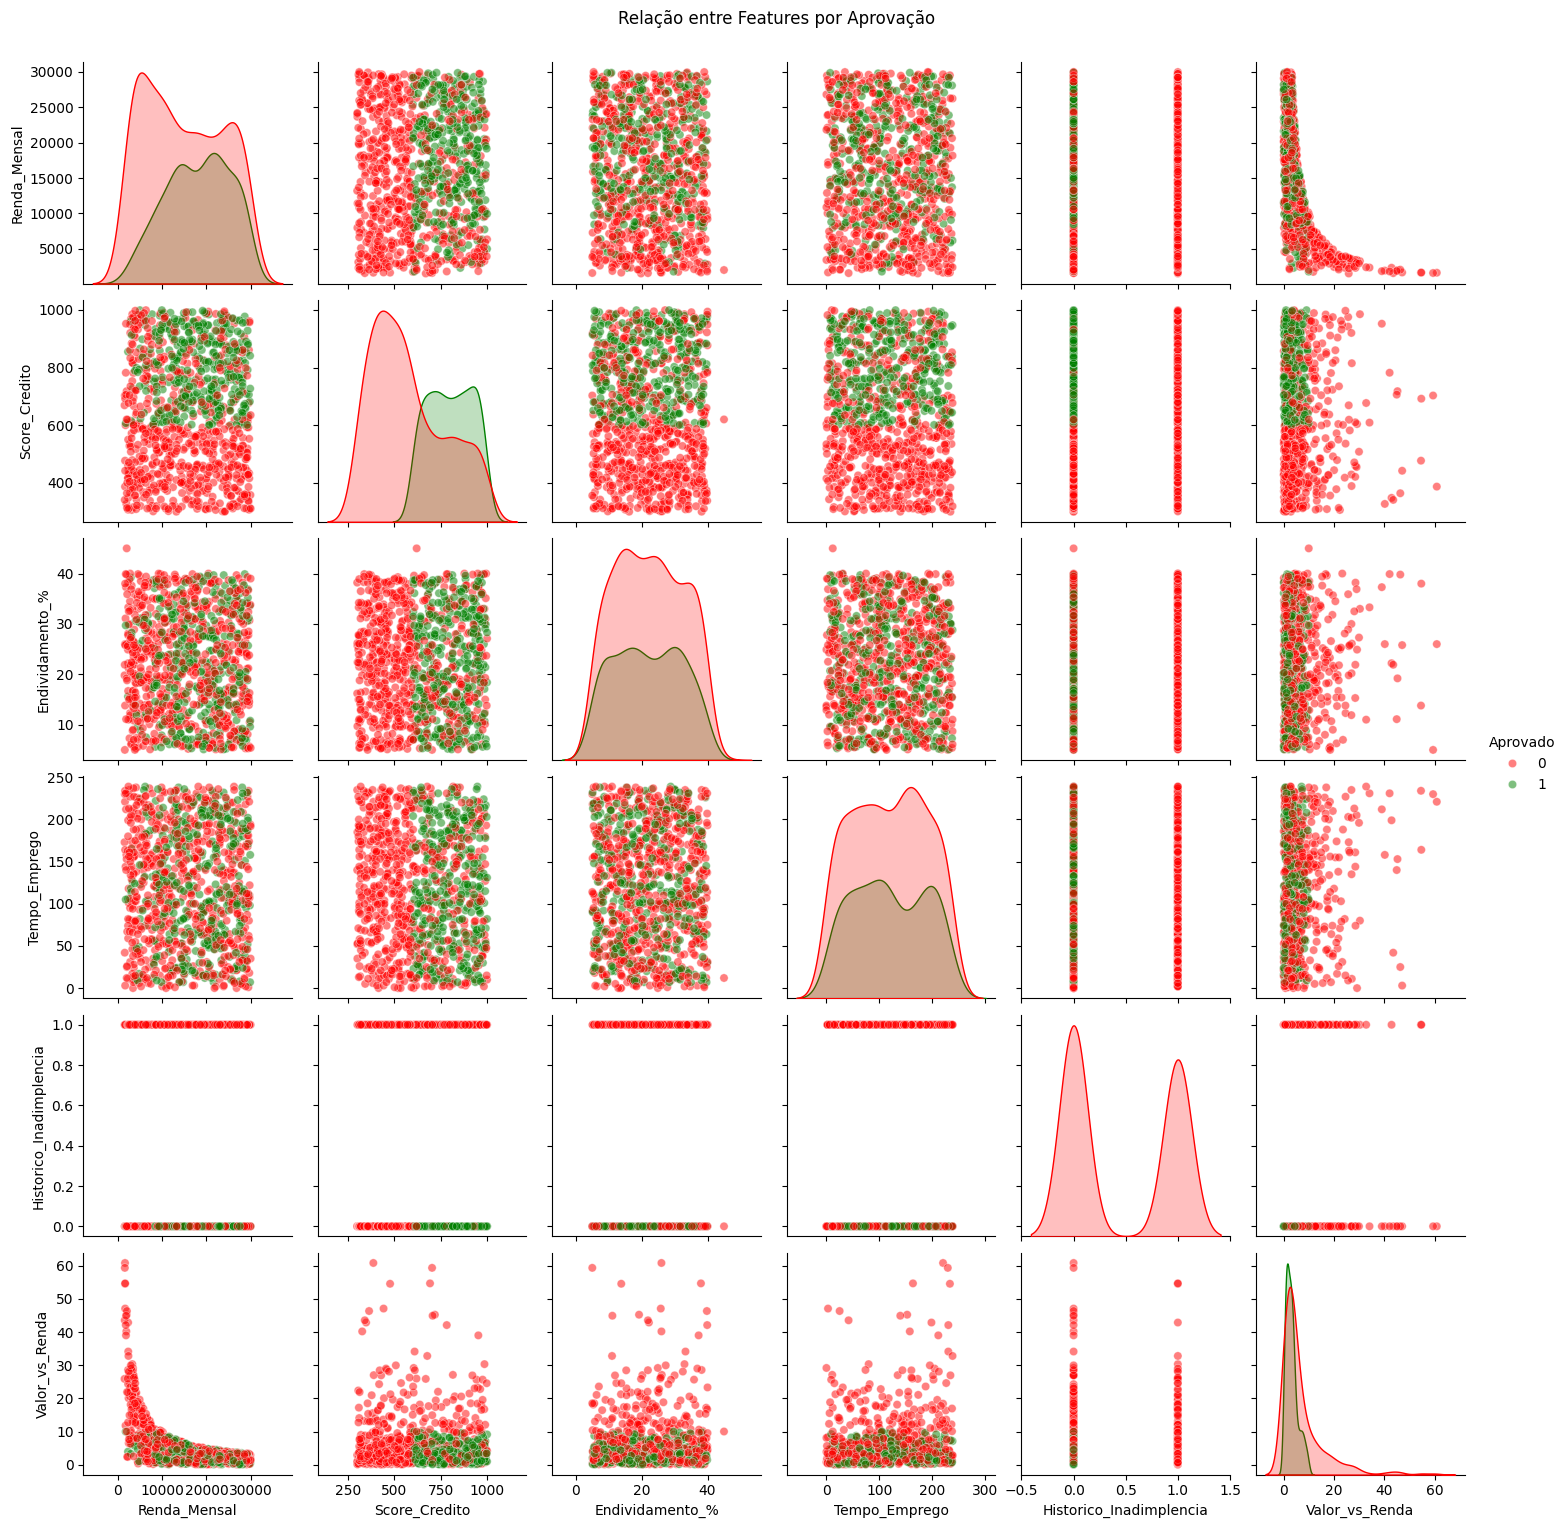

In [ ]:
sns.pairplot(df[features + ["Aprovado"]], hue="Aprovado", palette={0:"red", 1:"green"}, plot_kws={'alpha':0.5})
plt.suptitle("Relação entre Features por Aprovação", y=1.02)
plt.show()


## 📊 Densidade do Score de Crédito por Aprovação

Este gráfico de densidade (`kdeplot`) mostra a distribuição do Score de Crédito para clientes aprovados (verde) e não aprovados (vermelho).  
Ele ajuda a entender como os scores se comportam em cada grupo, evidenciando diferenças na concentração e dispersão dos valores entre aprovados e negados.


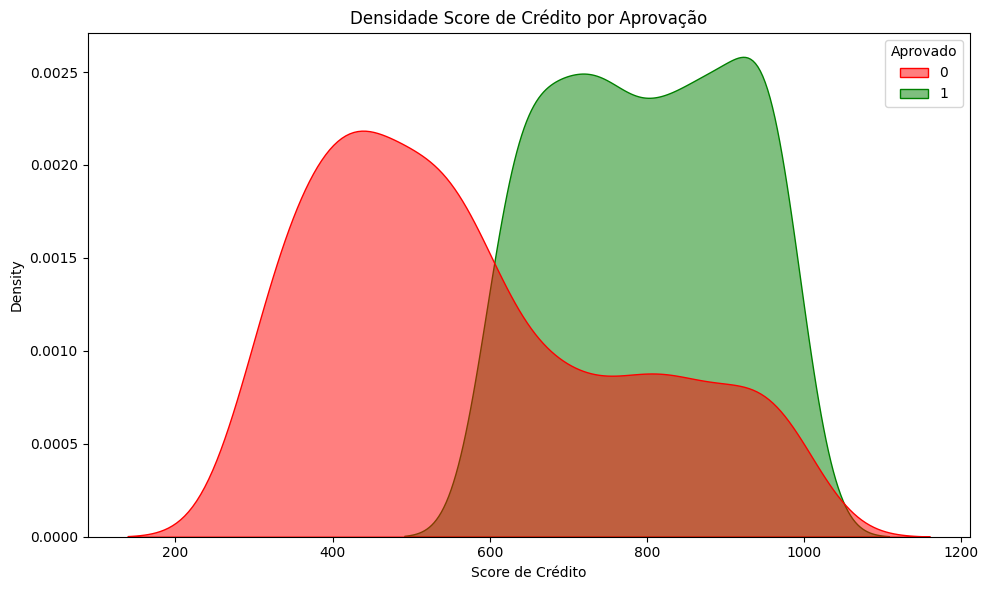

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, x="Score_Credito", hue="Aprovado", fill=True, common_norm=False, alpha=0.5, palette=["red", "green"])
plt.title("Densidade Score de Crédito por Aprovação")
plt.xlabel("Score de Crédito")
plt.tight_layout()
plt.show()


In [ ]:
!pip install shap

## 🔎 SHAP - Explicação Global do Modelo

Este código utiliza a biblioteca SHAP para interpretar o modelo Random Forest treinado.  
O `Explainer` calcula os valores SHAP para o conjunto de treino, que indicam a contribuição de cada feature para as previsões do modelo.  
O gráfico de resumo (`summary_plot`) mostra a importância das variáveis e como seus valores impactam o resultado, facilitando o entendimento global do comportamento do modelo.



🔎 SHAP - Explicação Global (summary plot):


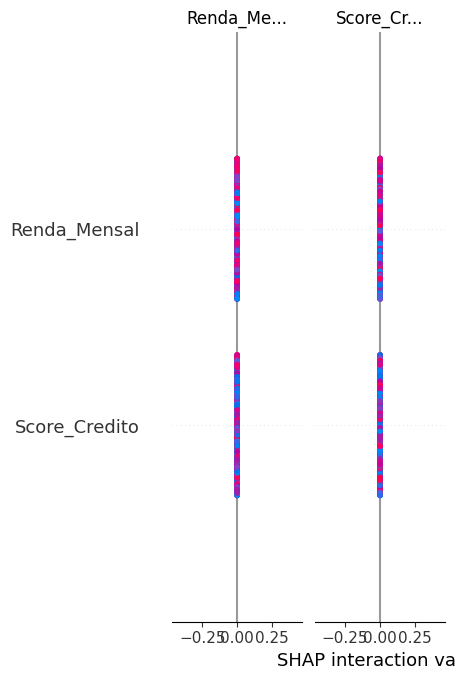

In [ ]:
import shap

# ------------------ SHAP - EXPLICAÇÃO GLOBAL ------------------
explainer_shap = shap.Explainer(pipeline.named_steps["randomforestclassifier"], X_train, feature_names=features)
shap_values = explainer_shap(X_train)

print("\n🔎 SHAP - Explicação Global (summary plot):")
shap.summary_plot(shap_values, X_train, plot_type="dot")
